In [1]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.init
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)

if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

In [4]:
mnist_train = dset.MNIST(root='MNIST_data/', 
                          train=True, # train data
                          transform=transforms.ToTensor(), # tensor form
                          download=True)

mnist_test = dset.MNIST(root='MNIST_data/', 
                         train=False, # test data
                         transform=transforms.ToTensor(), 
                         download=True)

In [5]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [33]:
# linear autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Linear(28*28,20)
        self.decoder = nn.Linear(20,28*28)   
                
    def forward(self,x):
        x = x.view(batch_size,-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size,1,28,28)
        return out

In [34]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),                            # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)                                       # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),                          # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),                         # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),                    # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),                       # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),                        # batch x 16 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),                       # batch x 1 x 28 x 28
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [35]:
print(device)

# linear
# model = Autoencoder().to(device)
# loss_func = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda


In [37]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        
        optimizer.zero_grad()
        
        output = encoder(x)
        output = decoder(output)
        
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()
        
    
    print(loss.cpu().data)
    loss_arr.append(loss.cpu().data.numpy())

tensor(0.0072)
tensor(0.0048)
tensor(0.0035)
tensor(0.0032)
tensor(0.0027)


torch.Size([256, 28, 28])


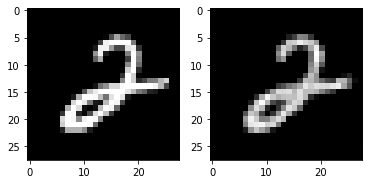

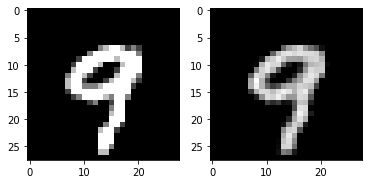

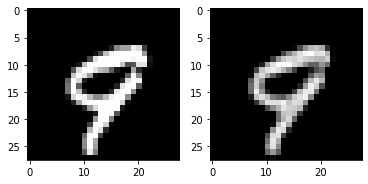

In [38]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(3):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [41]:
with torch.no_grad():
    for i in range(1):
        for j,[image,label] in enumerate(test_loader):
            x = image.to(device)

            optimizer.zero_grad()
            output = encoder(x)
            output = decoder(output)


    print(loss)      

tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)


torch.Size([256, 28, 28])


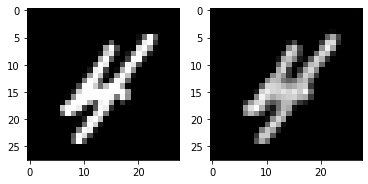

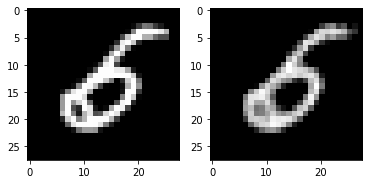

In [42]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()